In [1]:
import pandas as pd

# Load the data
file_path = '..../Data_2023-2024.csv'
df = pd.read_csv(file_path)

#print(df.head())

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

#Convert the Date to a DateTime Object
df['CreatedDate'] = pd.to_datetime(df['CreatedDate'])

# Extract year and month from date
df['Year'] = df['CreatedDate'].dt.year
df['Month'] = df['CreatedDate'].dt.month
df['Day'] = df['CreatedDate'].dt.day
df['Weekdat'] = df['CreatedDate'].dt.weekday

#Count Orders Per Month Per Model
df_demand = df.groupby(['MODEL',df['CreatedDate'].dt.to_period('M')]).size().reset_index(name='Order_Count')
df_demand.rename(columns={'Date':'Month'},inplace=True)
df_demand['CreatedDate'] = df_demand['CreatedDate'].dt.strftime('%Y-%m')
print(df_demand.head())
#print(df.head())

                       MODEL CreatedDate  Order_Count
0        AVANTE 1.6 AUTO "S"     2023-06            4
1  AVANTE 1.6 DCT HYBRID "S"     2023-11            1
2  AVANTE 1.6 DCT HYBRID "S"     2024-01           15
3  AVANTE 1.6 DCT HYBRID "S"     2024-02           25
4  AVANTE 1.6 DCT HYBRID "S"     2024-03            5


C:\Users\jasmine.thant\AppData\Local\Temp\ipykernel_19672\4269900881.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  df['CreatedDate'] = pd.to_datetime(df['CreatedDate'])


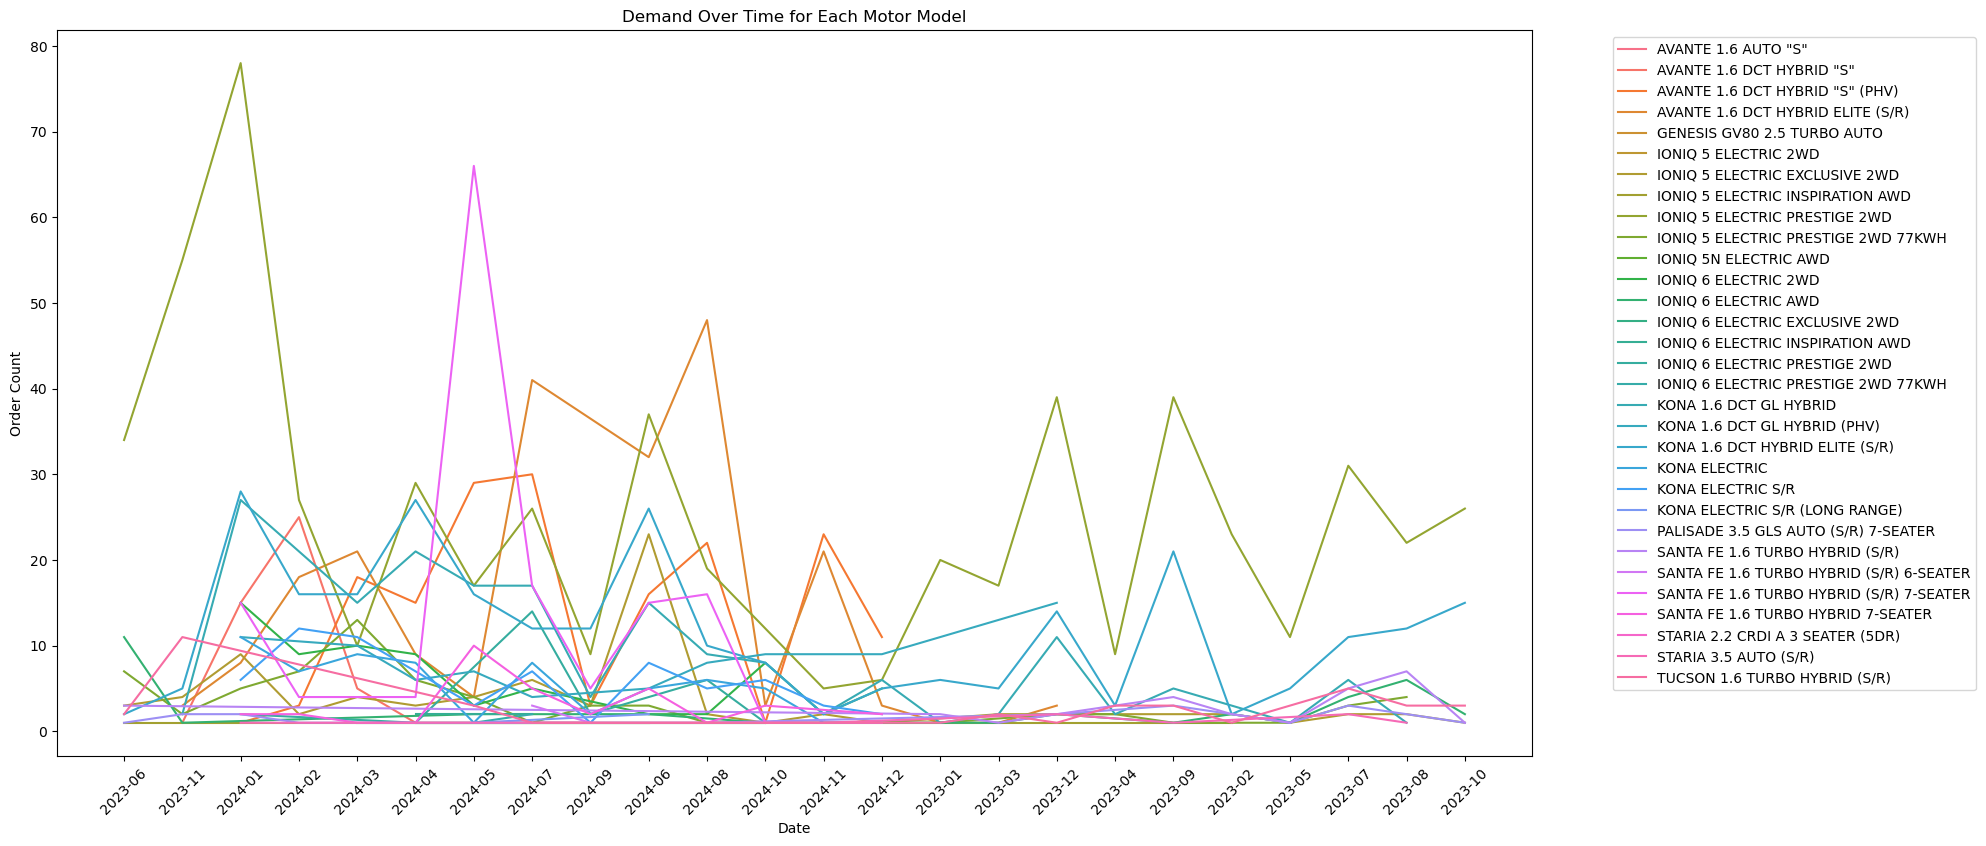

In [3]:
#Exploratory Data Analysis (EDA)
#This visualization will show the demand trends for each motor model over time.
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(20,8))

sns.lineplot(x='CreatedDate',y='Order_Count',hue='MODEL',data=df_demand)

# Move the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Adjust layout to make room for the legend
plt.tight_layout()

plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Order Count')
plt.title('Demand Over Time for Each Motor Model')
plt.show()

In [4]:
#Create Lag Features
#To forecast demand, create lag features. These features represent the demand in the previous months, 
#which will be helpful for predicting future demand.

#demand in the previous month
df_demand['Lag_1'] = df_demand.groupby('MODEL')['Order_Count'].shift(1)
#demand for the past 2 months
df_demand['Lag_2'] = df_demand.groupby('MODEL')['Order_Count'].shift(2)
#Drop any rows with NaN values due to lagging
df_demand.dropna(inplace=True)

#Split Data for Training and Testing
#To evaluate the model’s performance, split the data into training and testing sets. 
#Usually, use the earlier data for training and the more recent data for testing.
from sklearn.model_selection import train_test_split
X = df_demand[['Lag_1','Lag_2']]
y = df_demand['Order_Count']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,shuffle=False)
print(df_demand.head())

                       MODEL CreatedDate  Order_Count  Lag_1  Lag_2
3  AVANTE 1.6 DCT HYBRID "S"     2024-02           25   15.0    1.0
4  AVANTE 1.6 DCT HYBRID "S"     2024-03            5   25.0   15.0
5  AVANTE 1.6 DCT HYBRID "S"     2024-04            1    5.0   25.0
6  AVANTE 1.6 DCT HYBRID "S"     2024-05            1    1.0    5.0
7  AVANTE 1.6 DCT HYBRID "S"     2024-07            1    1.0    1.0


In [5]:
#Linear Regression 
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train,y_train)
y_pred_linear = linear_model.predict(X_test)

In [6]:
#Decision Tree
from sklearn.tree import DecisionTreeRegressor
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train,y_train)
y_pred_tree = tree_model.predict(X_test)

In [7]:
#Random Forest
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100,max_depth=10,random_state=42)
rf_model.fit(X_train,y_train)
y_pred_rf = rf_model.predict(X_test)

In [8]:
#Ridge Regression
from sklearn.linear_model import Ridge
ridge_model = Ridge(alpha=1.0)
ridge_model.fit(X_train, y_train)
y_pred_ridge = ridge_model.predict(X_test)

In [9]:
#Evaluate the Model
#Evaluate the performance of your model using metrics like Mean Squared Error (MSE) or R-squared.
from sklearn.metrics import mean_squared_error, r2_score

#Evaluate Linear Regression
mse_linear = mean_squared_error(y_test,y_pred_linear)
r2_linear = r2_score(y_test,y_pred_linear)
print(f'Linear Regression MSE:{mse_linear}')
print(f'Linear Regression R-squared:{r2_linear}')

#Evaluate Decision Tree
mse_tree = mean_squared_error(y_test,y_pred_tree)
r2_tree = r2_score(y_test,y_pred_tree)
print(f'Decision Tree MSE:{mse_tree}')
print(f'Decision Tree R-squared:{r2_tree}')

#Random Forest
mse_rf = mean_squared_error(y_test,y_pred_rf)
r2_rf = r2_score(y_test,y_pred_rf)
print(f'Decision Tree MSE:{mse_rf}')
print(f'Decision Tree R-squared:{r2_rf}')

#Ridge Regression
mse_ridge = mean_squared_error(y_test,y_pred_ridge)
r2_ridge = r2_score(y_test,y_pred_ridge)
print(f'Decision Tree MSE:{mse_ridge}')
print(f'Decision Tree R-squared:{r2_ridge}')

Linear Regression MSE:93.78022926868229
Linear Regression R-squared:-0.02702622282058398
Decision Tree MSE:94.10291570341894
Decision Tree R-squared:-0.030560095928033437
Decision Tree MSE:108.5978284122028
Decision Tree R-squared:-0.18929990244701478
Decision Tree MSE:93.77940898137098
Decision Tree R-squared:-0.027017239513702274


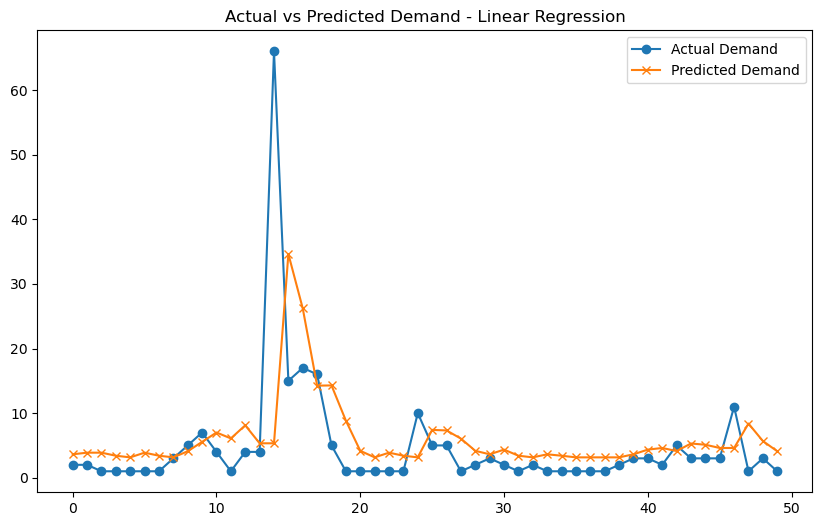

In [10]:
# Plot actual vs predicted demand with Linear Regression
plt.figure(figsize=(10,6))
plt.plot(y_test.values,label='Actual Demand',marker='o')
plt.plot(y_pred_linear, label='Predicted Demand', marker='x')
plt.title('Actual vs Predicted Demand - Linear Regression')
plt.legend()
plt.show()

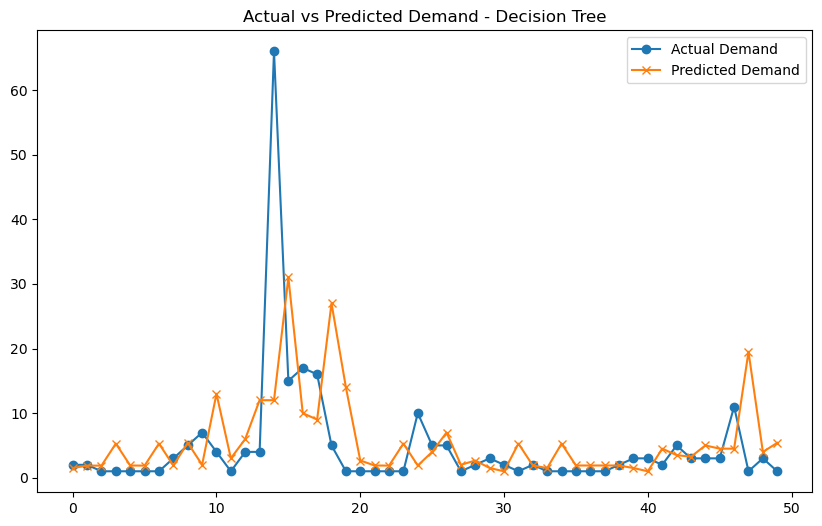

In [11]:
# Plot actual vs predicted demand with Decision Tree
plt.figure(figsize=(10,6))
plt.plot(y_test.values,label='Actual Demand',marker='o')
plt.plot(y_pred_tree, label='Predicted Demand', marker='x')
plt.title('Actual vs Predicted Demand - Decision Tree')
plt.legend()
plt.show()

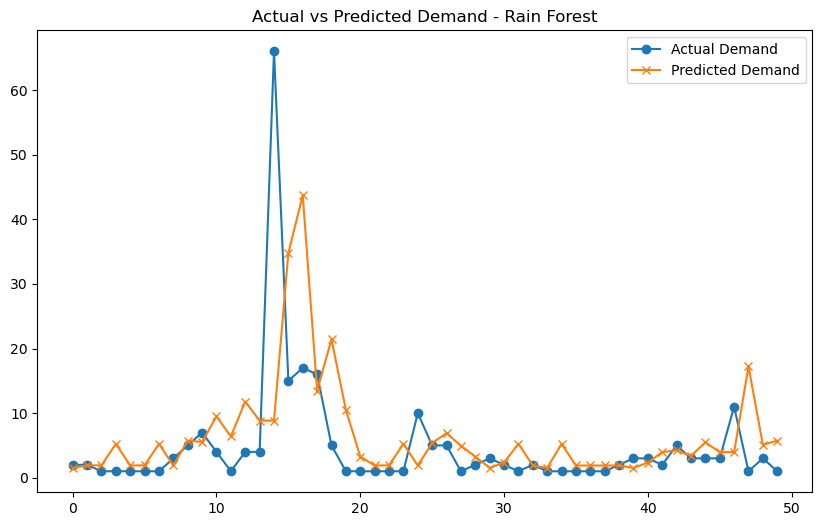

In [12]:
# Plot actual vs predicted demand with Rain Forest
plt.figure(figsize=(10,6))
plt.plot(y_test.values,label='Actual Demand',marker='o')
plt.plot(y_pred_rf,label='Predicted Demand',marker='x')
plt.title('Actual vs Predicted Demand - Rain Forest')
plt.legend()
plt.show()

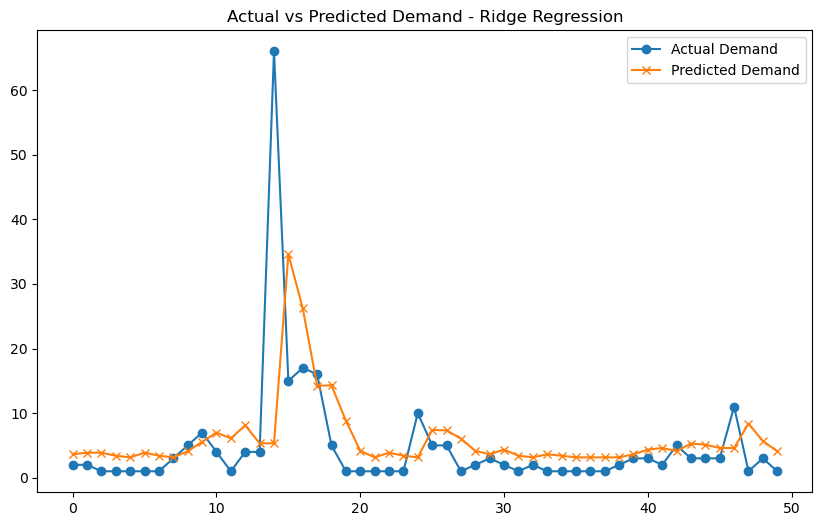

In [13]:
# Plot actual vs predicted demand with Ridge Regression
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Demand', marker='o')
plt.plot(y_pred_ridge, label='Predicted Demand', marker='x')
plt.title('Actual vs Predicted Demand - Ridge Regression')
plt.legend()
plt.show()

In [14]:
#Forecast Future Demand
#To forecast demand for the upcoming months
input_model = str(input())
recent_data = df_demand[df_demand['MODEL'] == input_model].iloc[-1]
previous_month_lag_1 = recent_data['Lag_1']
previous_month_lag_2 = recent_data['Lag_2']

#Linear Regression
future_demand = linear_model.predict([[previous_month_lag_1, previous_month_lag_2]])
print(f'Predicted Demand for next month - Linear: {future_demand}')

#Decision Tree
future_demand2 = tree_model.predict([[previous_month_lag_1, previous_month_lag_2]])
print(f'Predicted Demand for next month - Decision: {future_demand2}')

#Rain Forest
future_demand3 = rf_model.predict([[previous_month_lag_1, previous_month_lag_2]])
print(f'Predicted Demand for next month - Rain Forest: {future_demand3}')

#Ridge Regression
future_demand4 = ridge_model.predict([[previous_month_lag_1, previous_month_lag_2]])
print(f'Predicted Demand for next month - Ridge: {future_demand4}')

TUCSON 1.6 TURBO HYBRID (S/R)
Predicted Demand for next month - Linear: [4.0992382]
Predicted Demand for next month - Decision: [5.4]
Predicted Demand for next month - Rain Forest: [5.74351263]
Predicted Demand for next month - Ridge: [4.09934796]


C:\Users\jasmine.thant\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(
C:\Users\jasmine.thant\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(
C:\Users\jasmine.thant\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
C:\Users\jasmine.thant\AppData\Local\anaconda3\lib\site-packages\sklearn\base.py:420: UserWarning: X does not have valid feature names, but Ridge was fitted with feature names
  warnings.warn(
